## Import modules

In [1]:
import json
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import time
import seaborn as sns

from datetime import datetime

### Reading data

In [2]:
data = pd.read_csv('Full_data.csv')

### Look for dimension, types, missing values and duplicates

In [3]:
print(data.shape)
print(data.columns)
data.head(3)

(10137, 23)
Index(['status_id', 'user_id', 'created_at', 'screen_name', 'text', 'source',
       'reply_to_status_id', 'reply_to_user_id', 'reply_to_screen_name',
       'is_quote', 'is_retweet', 'favourites_count', 'retweet_count',
       'country_code', 'place_full_name', 'place_type', 'followers_count',
       'friends_count', 'account_lang', 'account_created_at', 'verified',
       'lang', 'source_tweet'],
      dtype='object')


,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang,source_tweet
0,1244051801516711938,803282972317204480,2020-03-29 00:00:37,redcomunitariat,Este lunes estaremos hablando sobre la situaci...,Twitter for iPhone,NaN,NaN,NaN,False,False,1119,4,CO,"Bogotá, D.C., Colombia",city,2710,365,NaN,2016-11-28 17:02:39,False,es,https://twitter.com/redcomunitariat/status/124...
1,1244052036511051778,2476348920,2020-03-29 00:01:33,SebasCamposCol,Aquí con frío🥶 viendo cómo pasa la cuarentena🕯...,Twitter for Android,NaN,NaN,NaN,False,False,768,0,CO,"Bogotá, D.C., Colombia",city,4194,204,NaN,2014-05-04 04:11:55,False,es,https://twitter.com/SebasCamposCol/status/1244...
2,1244052338412847104,239176842,2020-03-29 00:02:45,Jonathan_518,"Hoy es #sábado, apenas es hora de bañarme y or...",Twitter for iPhone,NaN,NaN,NaN,False,False,18,0,CO,"Guarne, Colombia",city,286,914,NaN,2011-01-17 00:53:22,False,es,https://twitter.com/Jonathan_518/status/124405...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10137 entries, 0 to 10136
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   status_id             10137 non-null  int64  
 1   user_id               10137 non-null  int64  
 2   created_at            10137 non-null  object 
 3   screen_name           10137 non-null  object 
 4   text                  10137 non-null  object 
 5   source                10137 non-null  object 
 6   reply_to_status_id    1451 non-null   float64
 7   reply_to_user_id      1794 non-null   float64
 8   reply_to_screen_name  1794 non-null   object 
 9   is_quote              10137 non-null  bool   
 10  is_retweet            10137 non-null  bool   
 11  favourites_count      10137 non-null  int64  
 12  retweet_count         10137 non-null  int64  
 13  country_code          9825 non-null   object 
 14  place_full_name       9825 non-null   object 
 15  place_type         

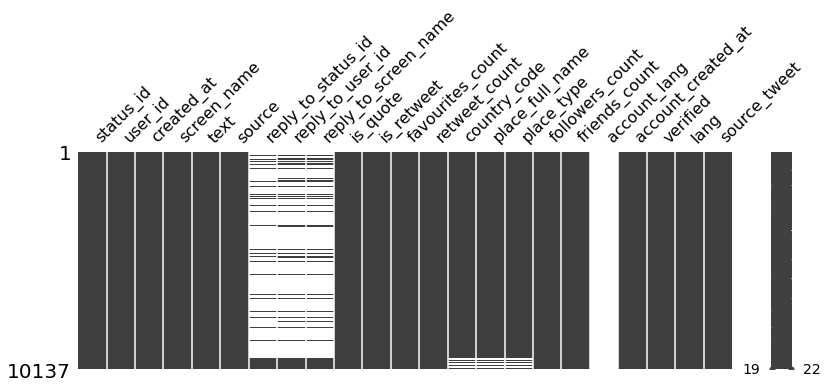

In [5]:
msno.matrix(data, figsize=(13, 4))

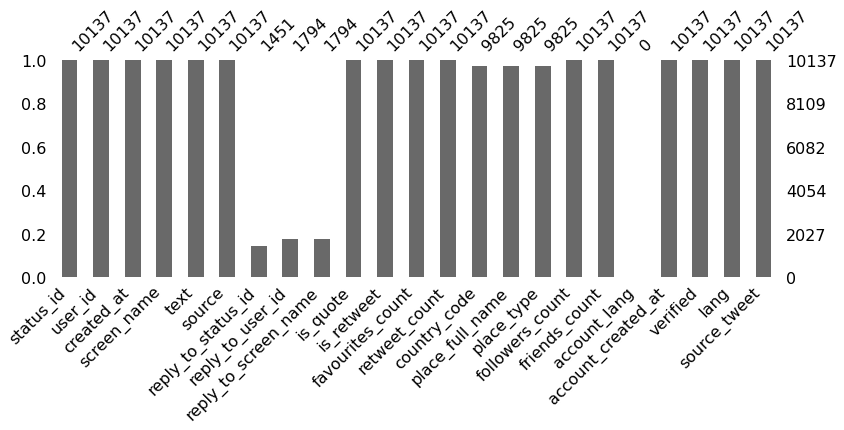

In [6]:
msno.bar(data, figsize=(13, 4))

#### Since the columns account_lang doesn't have any value, then we procced to drop it 

In [7]:
data_ = data.drop(['account_lang'], axis=1).copy()

#### Here we notice that there are about 400 tweet repeat it, so we procced to delete them.

In [8]:
print("Unique values:")
data_.nunique()

Unique values:


status_id               9703
user_id                 3387
created_at              9682
screen_name             3393
text                    9702
source                    11
reply_to_status_id      1009
reply_to_user_id         852
reply_to_screen_name     854
is_quote                   2
is_retweet                 1
favourites_count        4977
retweet_count            113
country_code               2
place_full_name          432
place_type                 4
followers_count         3634
friends_count           2631
account_created_at      3387
verified                   2
lang                      22
source_tweet            9703
dtype: int64

In [9]:
data_.groupby('status_id').count().sort_values(by='user_id', ascending=False).head()

,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_created_at,verified,lang,source_tweet
status_id,,,,,,,,,,,,,,,,,,,,,
1246926034873827328,12,12,12,12,12,12,12,12,12,12,12,12,0,0,0,12,12,12,12,12,12
1244712607069745152,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
1243245611102732288,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
1244291628204019712,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
1244357680673759232,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8


In [10]:
data_[data_['status_id'] == 1246926034873827328]['text']

9688     @CoordinaValle La marcha del 8M y el evento de...
9689     @CoordinaValle La marcha del 8M y el evento de...
9735     @CoordinaValle La marcha del 8M y el evento de...
9736     @CoordinaValle La marcha del 8M y el evento de...
9797     @CoordinaValle La marcha del 8M y el evento de...
9798     @CoordinaValle La marcha del 8M y el evento de...
9876     @CoordinaValle La marcha del 8M y el evento de...
9877     @CoordinaValle La marcha del 8M y el evento de...
9966     @CoordinaValle La marcha del 8M y el evento de...
9967     @CoordinaValle La marcha del 8M y el evento de...
10066    @CoordinaValle La marcha del 8M y el evento de...
10067    @CoordinaValle La marcha del 8M y el evento de...
Name: text, dtype: object

In [11]:
data1 = data_.drop_duplicates('status_id', keep='first').copy()

In [12]:
print(data1.shape)
data1.head(3)

(9703, 22)


,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_created_at,verified,lang,source_tweet
0,1244051801516711938,803282972317204480,2020-03-29 00:00:37,redcomunitariat,Este lunes estaremos hablando sobre la situaci...,Twitter for iPhone,NaN,NaN,NaN,False,False,1119,4,CO,"Bogotá, D.C., Colombia",city,2710,365,2016-11-28 17:02:39,False,es,https://twitter.com/redcomunitariat/status/124...
1,1244052036511051778,2476348920,2020-03-29 00:01:33,SebasCamposCol,Aquí con frío🥶 viendo cómo pasa la cuarentena🕯...,Twitter for Android,NaN,NaN,NaN,False,False,768,0,CO,"Bogotá, D.C., Colombia",city,4194,204,2014-05-04 04:11:55,False,es,https://twitter.com/SebasCamposCol/status/1244...
2,1244052338412847104,239176842,2020-03-29 00:02:45,Jonathan_518,"Hoy es #sábado, apenas es hora de bañarme y or...",Twitter for iPhone,NaN,NaN,NaN,False,False,18,0,CO,"Guarne, Colombia",city,286,914,2011-01-17 00:53:22,False,es,https://twitter.com/Jonathan_518/status/124405...


#### There's something weird, there are tweets with the same text, but they seem to have different ids, and be publish in differents dates

In [13]:
for i in data1[data1['text'].duplicated()].index[:3]:
    print(f"[ Id: {data1.loc[i][data1.columns[0]]},\n" 
          f" user id: {data1.loc[i][data1.columns[1]]},\n"
          f" date: {data1.loc[i][data1.columns[2]]},\n"
          f" text: {data1.loc[i][data1.columns[4]]}\n]\n")

[ Id: 1245834468935340033,
 user id: 376451765,
 date: 2020-04-02 22:04:18,
 text: #FelizJueves #QuedateEnCasa #EstaEnTusManos #LaVidaEsSagrada #COVID19 #HaciendoCiudad #ConcejodeBucaramanga #LuisAvila #Bucaramanga
]

[ Id: 1245881819741990914,
 user id: 376451765,
 date: 2020-04-03 01:12:27,
 text: #FelizJueves #QuedateEnCasa #EstaEnTusManos #LaVidaEsSagrada #COVID19 #HaciendoCiudad #ConcejodeBucaramanga #LuisAvila #Bucaramanga
]

[ Id: 1247637085756035075,
 user id: 376451765,
 date: 2020-04-07 21:27:15,
 text: #FelizMartes #QuedateEnCasa #EstaEnTusManos #LaVidaEsSagrada #COVID19 #HaciendoCiudad #ConcejodeBucaramanga #LuisAvila #Bucaramanga
]



### Categorical variables
- screen_name
- source
- reply_to_screen_name
- is_quote
- place_full name
- place_type
- lang
- country_code

Number of screen_names: 9703
Number of unique screen_names: 3393


Text(0.5, 1.0, '25 most-frequent screenames for tweets')

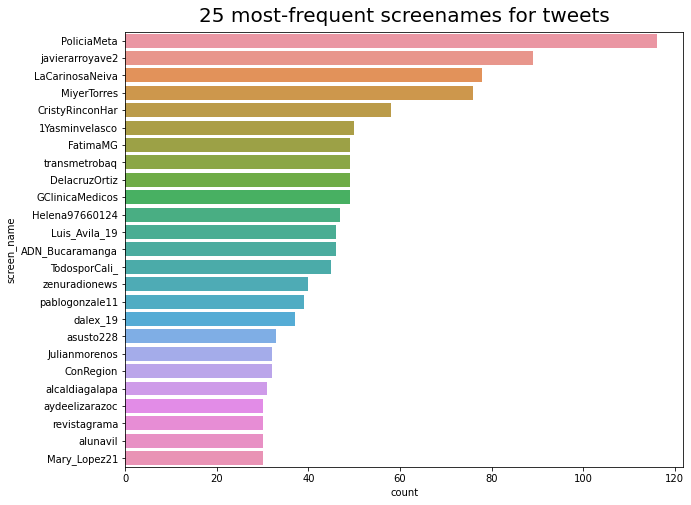

In [14]:
print(f"Number of screen_names: {data1['screen_name'].shape[0]}")
print(f"Number of unique screen_names: {len(set(data1['screen_name'].unique()))}")
first_twenty = data1['screen_name'].value_counts()[:25].index

plt.figure(figsize=(10, 8))
sns.countplot(y='screen_name', 
              data = data1[data1['screen_name'].apply(lambda x: x in first_twenty)],
              order =  data1[data1['screen_name'].apply(lambda x: x in first_twenty)]
              ['screen_name'].value_counts().sort_values(ascending=False).index)
              
plt.title("25 most-frequent screenames for tweets", fontsize=20, verticalalignment='bottom')

Text(0.5, 1.0, 'Source tweets')

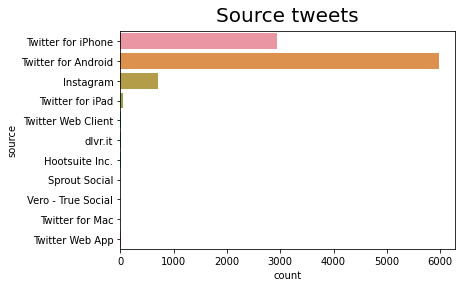

In [15]:
sns.countplot(y='source', data = data1) 
plt.title("Source tweets", fontsize=20, verticalalignment='bottom')

Number of replies screen_names: 9703
Number of unique replies screen_names: 855


Text(0.5, 1.0, '25 most-frequent screenames for replies tweets')

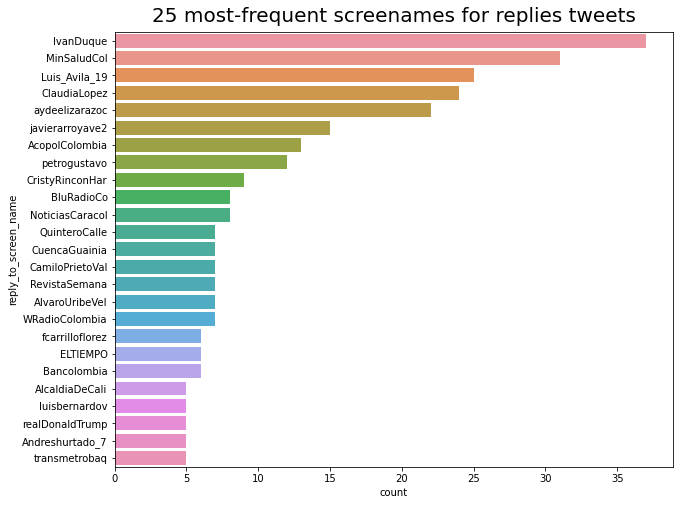

In [16]:
print(f"Number of replies screen_names: {data1['reply_to_screen_name'].shape[0]}")
print(f"Number of unique replies screen_names: {len(set(data1['reply_to_screen_name'].unique()))}")
first_twenty = data1['reply_to_screen_name'].value_counts()[:25].index

plt.figure(figsize=(10, 8))
sns.countplot(y='reply_to_screen_name', 
              data = data1[data1['reply_to_screen_name'].apply(lambda x: x in first_twenty)],
              order =  data1[data1['reply_to_screen_name'].apply(lambda x: x in first_twenty)]
              ['reply_to_screen_name'].value_counts().sort_values(ascending=False).index) 

plt.title("25 most-frequent screenames for replies tweets", fontsize=20, verticalalignment='bottom')

In [17]:
df_temp = data1[~data1['reply_to_screen_name'].isnull()].copy()

In [18]:
# print("\n\n".join(df_temp[df_temp['reply_to_screen_name'] == 'MinSaludCol']['text'].apply(lambda x:remove_links(x))))

#### Here we notice that the tweets that has more replies are the ones related to a colombian politician or a colombian entity.

Text(0.5, 1.0, 'Place type tweets')

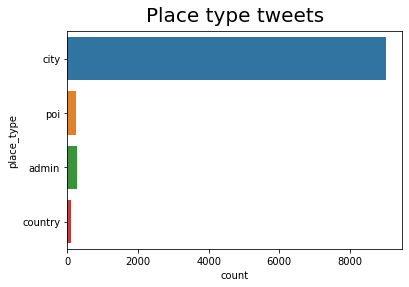

In [19]:
sns.countplot(y='place_type', data = data1) 
plt.title("Place type tweets", fontsize=20, verticalalignment='bottom')

Number of cities: 9023
Number of unique cities: 258


Text(0.5, 1.0, '10 most-frequent cities for tweets')

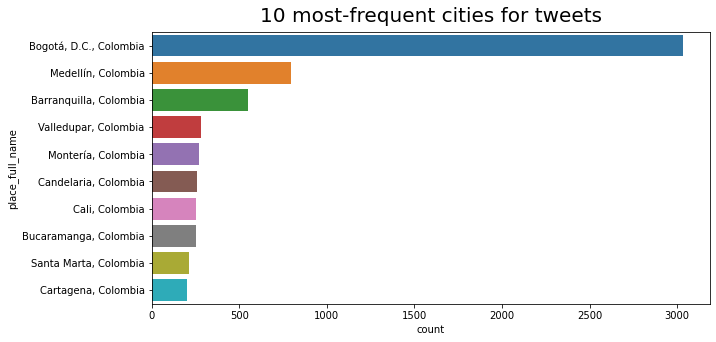

In [20]:
df = data1[data1['place_type'] == 'city'].copy()

print(f"Number of cities: {df['place_full_name'].shape[0]}")
print(f"Number of unique cities: {len(set(df['place_full_name'].unique()))}")
first_twenty = df['place_full_name'].value_counts()[:10].index

plt.figure(figsize=(10, 5))
sns.countplot(y='place_full_name', 
              data = df[df['place_full_name'].apply(lambda x: x in first_twenty)],
              order =  df[df['place_full_name'].apply(lambda x: x in first_twenty)]
              ['place_full_name'].value_counts().sort_values(ascending=False).index)

plt.title("10 most-frequent cities for tweets", fontsize=20, verticalalignment='bottom')


Number of poi: 239
Number of unique poi: 154


Text(0.5, 1.0, '10 most-frequent poi for tweets')

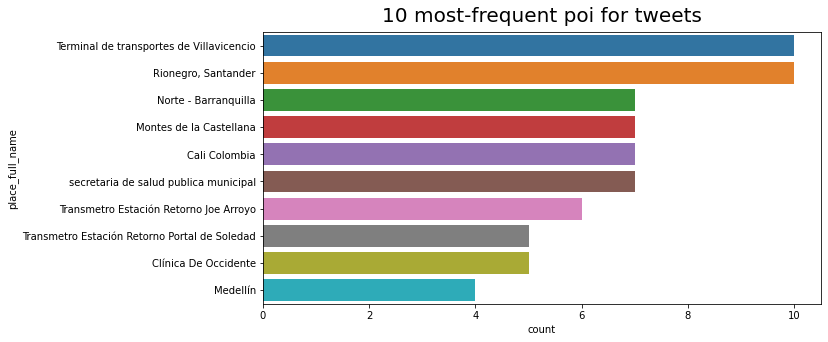

In [21]:
df = data1[data1['place_type'] == 'poi'].copy()

print(f"Number of poi: {df['place_full_name'].shape[0]}")
print(f"Number of unique poi: {len(set(df['place_full_name'].unique()))}")
first_twenty = df['place_full_name'].value_counts()[:10].index

plt.figure(figsize=(10, 5))
sns.countplot(y='place_full_name', 
              data = df[df['place_full_name'].apply(lambda x: x in first_twenty)],
              order =  df[df['place_full_name'].apply(lambda x: x in first_twenty)]
              ['place_full_name'].value_counts().sort_values(ascending=False).index)

plt.title("10 most-frequent poi for tweets", fontsize=20, verticalalignment='bottom')



Number of admin: 265
Number of unique admin: 19


Text(0.5, 1.0, '10 most-frequent admin for tweets')

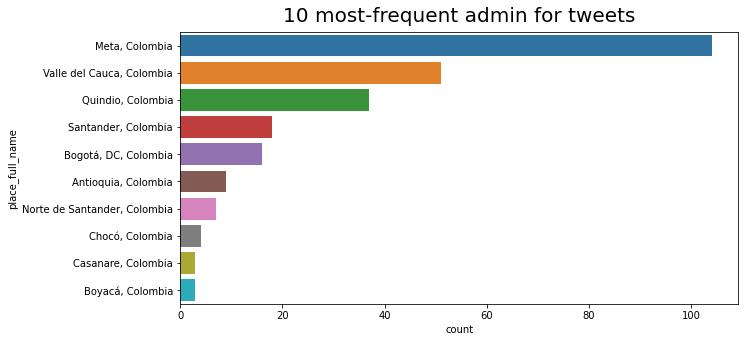

In [22]:
df = data1[data1['place_type'] == 'admin'].copy()

print(f"Number of admin: {df['place_full_name'].shape[0]}")
print(f"Number of unique admin: {len(set(df['place_full_name'].unique()))}")
first_twenty = df['place_full_name'].value_counts()[:10].index

plt.figure(figsize=(10, 5))
sns.countplot(y='place_full_name', 
              data = df[df['place_full_name'].apply(lambda x: x in first_twenty)],
              order =  df[df['place_full_name'].apply(lambda x: x in first_twenty)]
              ['place_full_name'].value_counts().sort_values(ascending=False).index)

plt.title("10 most-frequent admin for tweets", fontsize=20, verticalalignment='bottom')


Text(0.5, 1.0, 'Country code tweets')

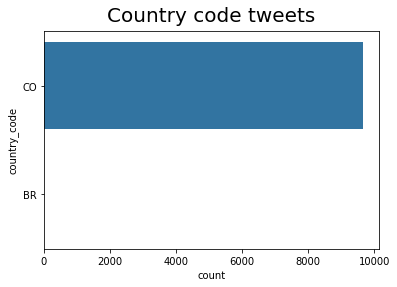

In [23]:
sns.countplot(y='country_code', data = data1) 
plt.title("Country code tweets", fontsize=20, verticalalignment='bottom')

#### Since all tweets are from Colombia is not need it to have he feature Country code

In [24]:
data2 = data1[data1['country_code'] == 'CO'].drop(['country_code'], axis=1).copy()
data2['place_full_name'] = data2['place_full_name'].apply(lambda x: x.split(',')[0])

In [25]:
cities_population = {'Bogotá': 7413000,
                     'Medellín': 2529403,
                     'Barranquilla': 1274250,
                     'Valledupar': 490075,
                     'Montería': 460223,
                     'Candelaria': 23985,
                     'Cali': 2471474,
                     'Bucaramanga': 581130,
                     'Santa Marta': 515556,
                     'Cartagena': 1036412
                    }

Number of places: 9642
Number of unique places: 418


Text(0.5, 1.0, '10 most-frequent place_full_name for tweets')

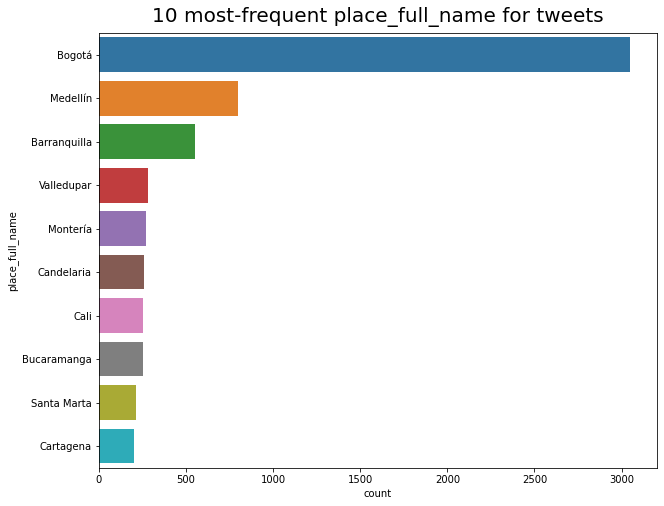

In [26]:
print(f"Number of places: {data2['place_full_name'].shape[0]}")
print(f"Number of unique places: {len(set(data2['place_full_name'].unique()))}")
first_twenty = data2['place_full_name'].value_counts()[:10].index

plt.figure(figsize=(10, 8))
sns.countplot(y='place_full_name', 
              data = data2[data2['place_full_name'].apply(lambda x: x in first_twenty)],
              order =  data2[data2['place_full_name'].apply(lambda x: x in first_twenty)]
              ['place_full_name'].value_counts().sort_values(ascending=False).index)

plt.title("10 most-frequent place_full_name for tweets", fontsize=20, verticalalignment='bottom')

#### We notice that most of the tweets are from Bogotá, however there are more people in Bogotá than in other cities, so we're going to normalize data with population per city

In [27]:
cities_names = data2['place_full_name'].value_counts()[:10].index.tolist()
cities_count = data2['place_full_name'].value_counts()[:10].tolist()
cities_count_ = [cities_count[i]/cities_population[cities_names[i]] for i in range(len(cities_count))]

<BarContainer object of 10 artists>

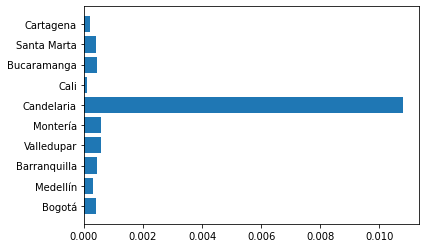

In [28]:
plt.barh(cities_names, cities_count_)

### Another interesting thing is that there are plenty of tweets of a Bogotá neighborhood (Candelaria). So, we're going to add it to Bogotá 

In [29]:
cities_names_ = cities_names.copy()
cities_count_ = cities_count.copy()


In [30]:
cities_names_.pop(5)
cities_count_[0] += cities_count_.pop(5)
cities_count_ = [cities_count_[i]/cities_population[cities_names_[i]] for i in range(len(cities_count_))]

In [31]:
cities_most_freq = [(cities_names_[i], cities_count_[i]) for i in range(len(cities_count_))]
cities_most_freq.sort(key=lambda x:x[1])
cities_most_freq

[('Cali', 0.00010236806051773153),
 ('Cartagena', 0.00019683291972690399),
 ('Medellín', 0.00031628016571499284),
 ('Santa Marta', 0.0004131461955636245),
 ('Bucaramanga', 0.00043191712697675217),
 ('Barranquilla', 0.00043241122228762017),
 ('Bogotá', 0.00044637798462161067),
 ('Valledupar', 0.0005774626332704178),
 ('Montería', 0.0005888449729804898)]

<BarContainer object of 9 artists>

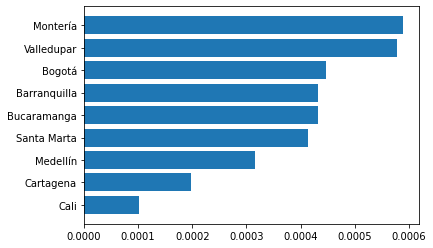

In [32]:
plt.barh([i[0] for i in cities_most_freq], [i[1] for i in cities_most_freq])

### Now, we see that actually the city with a bigger percentage of tweets is Monteria, however Bogotá doesn't stand behind, it is in third place. 

Text(0.5, 1.0, 'Languages')

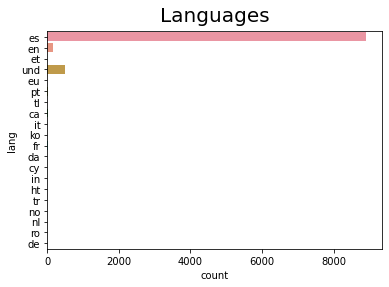

In [33]:
sns.countplot(y='lang', data = data2) 
plt.title("Languages", fontsize=20, verticalalignment='bottom')

### There are plenty of languages, since we are going to use NPL for spanish text, then we're going to drop tweets with other languages

In [34]:
data3 = data2[data2['lang'] == 'es'].copy()
print(data3.shape)

(8909, 21)


Text(0.5, 1.0, 'Quote tweets')

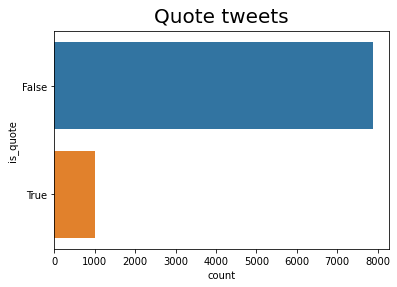

In [35]:
sns.countplot(y='is_quote', data = data3) 
plt.title("Quote tweets", fontsize=20, verticalalignment='bottom')

### Variables numericas

- favorite_count
- retweet_count
- followers_count
- friends_count

#### To see the behavior of these features over time, we're gonna plot them all tweets, and then split the data into replies and original tweets to do the same plots

In [36]:
data3.columns

Index(['status_id', 'user_id', 'created_at', 'screen_name', 'text', 'source',
       'reply_to_status_id', 'reply_to_user_id', 'reply_to_screen_name',
       'is_quote', 'is_retweet', 'favourites_count', 'retweet_count',
       'place_full_name', 'place_type', 'followers_count', 'friends_count',
       'account_created_at', 'verified', 'lang', 'source_tweet'],
      dtype='object')

In [37]:
data3['created_at'] = pd.to_datetime(data3['created_at'])
data3['account_created_at'] = pd.to_datetime(data3['account_created_at'])

In [38]:
data3['day'] = data3['created_at'].dt.to_period('d')

In [39]:
data3[['favourites_count', 'retweet_count', 'followers_count', 'friends_count']].describe()

,favourites_count,retweet_count,followers_count,friends_count
count,8909.000000,8909.000000,8.909000e+03,8909.000000
mean,8267.765518,3.173196,8.079546e+03,1508.830508
std,17778.678265,21.844543,5.086454e+04,4239.547439
min,0.000000,0.000000,0.000000e+00,0.000000
25%,533.000000,0.000000,2.350000e+02,283.000000
50%,2315.000000,0.000000,8.230000e+02,687.000000
75%,7631.000000,2.000000,3.525000e+03,1644.000000
max,272462.000000,1163.000000,1.857053e+06,104637.000000


In [40]:
def plot_time_series(df):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
    cols = ['favourites_count', 'retweet_count', 'followers_count', 'friends_count']
    for i in range(2):
        for j in range(2):
            col = cols[i+j] if i==0 else cols[i+j+1]
            axes[i][j].set_title(f'{col} over time', fontsize=15)
            df.groupby('day')[col].sum().plot(ax=axes[i][j])
            df.groupby('day')[col].sum().rolling(window=3).mean().plot(ax=axes[i][j])


In [41]:
print(f"First day: {min(data3['created_at'])}")
print(f"Last day: {max(data3['created_at'])}")

First day: 2020-03-26 18:37:06
Last day: 2020-04-30 23:59:12


### All tweets

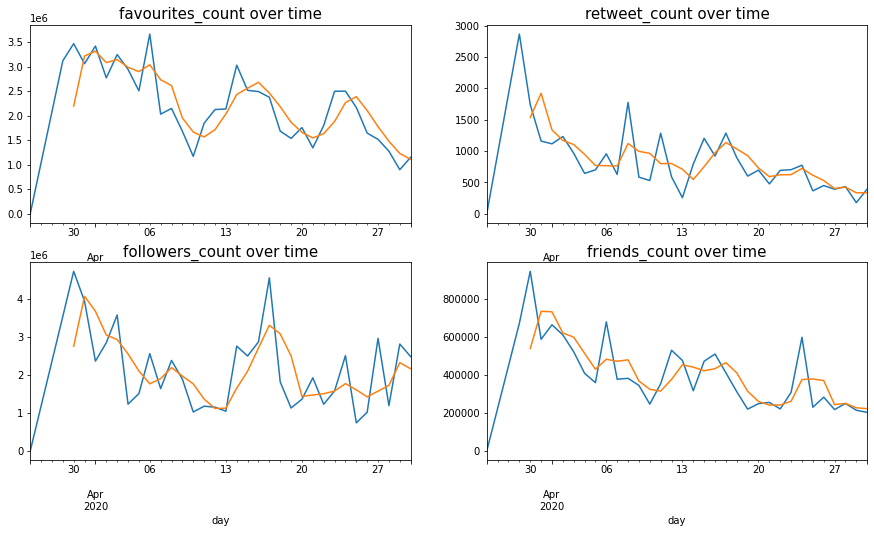

In [42]:
plot_time_series(data3)

### Original tweets

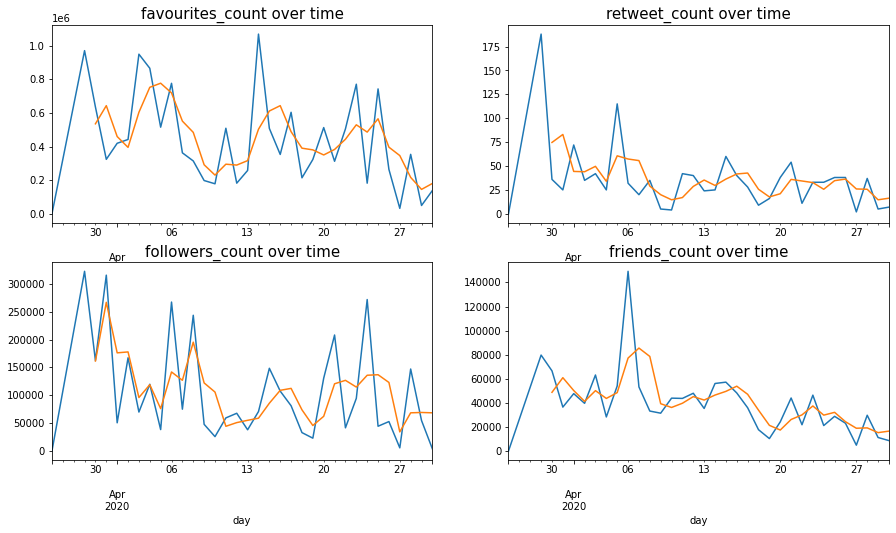

In [43]:
original_tweets = data3[~data3['reply_to_status_id'].isnull() ]
plot_time_series(original_tweets)

### Replies tweets

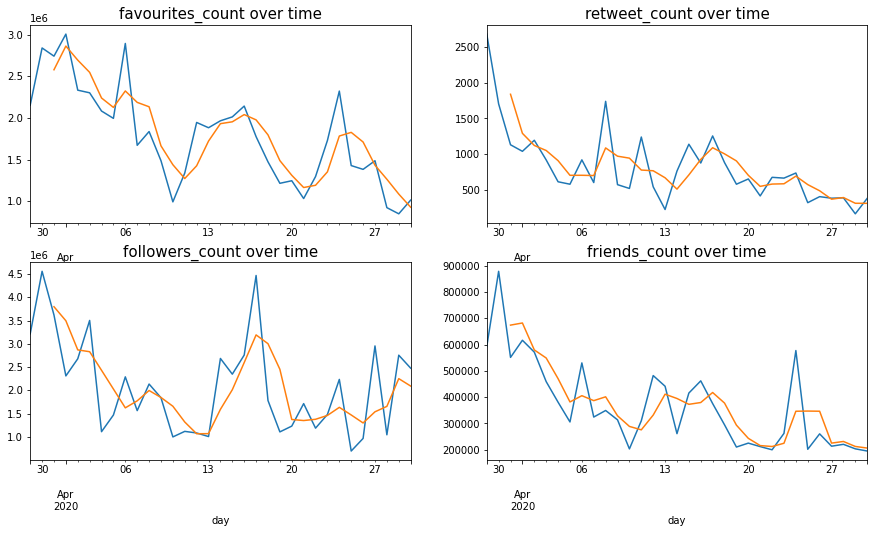

In [44]:
replies_tweets = data3[data3['reply_to_status_id'].isnull() ]
plot_time_series(replies_tweets)

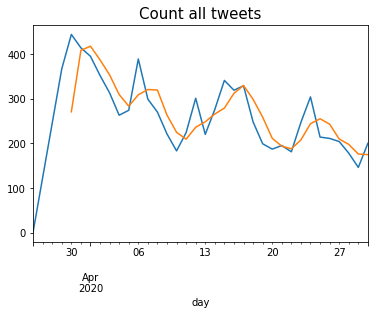

In [45]:
plt.title('Count all tweets', fontsize=15)
data3.groupby('day')['status_id'].count().plot()
data3.groupby('day')['status_id'].count().rolling(window=3).mean().plot()


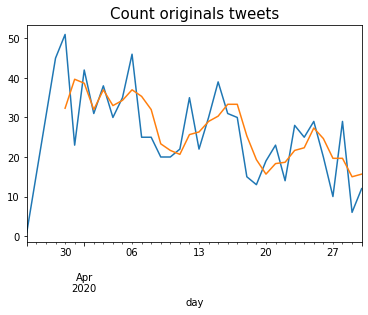

In [46]:
plt.title('Count originals tweets', fontsize=15)

original_tweets.groupby('day')['status_id'].count().plot()
original_tweets.groupby('day')['status_id'].count().rolling(window=3).mean().plot()

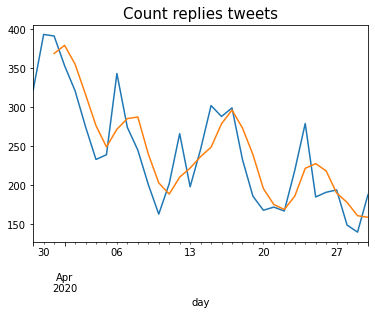

In [47]:
plt.title('Count replies tweets', fontsize=15)

replies_tweets.groupby('day')['status_id'].count().plot()
replies_tweets.groupby('day')['status_id'].count().rolling(window=3).mean().plot()

### Natural Language Proccesing

In [48]:
# !pip install wordcloud

In [49]:
import nltk
import contractions
import re
import emoji
import wordcloud as wc
import string


from collections import Counter

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_words = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [50]:
def create_wordcloud(text, plt_):
    wordcloud = wc.WordCloud(max_font_size=50,
                          max_words=100,
                          scale=10,
                          background_color="white")\
                          .generate(text)
    plt.figure(figsize=(10,5))
    plt_.imshow(wordcloud, interpolation="bilinear")
    plt_.axis("off")
#     plt.show()
    
def remove_links(text):
    text_ = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    return text_


def remove_space(text):
    text_ = re.sub(r'[\r|\n|\r\n]+', '\n', text)
    return text_


def extract_emojis(text):
     return ''.join(c for c in text if c in emoji.UNICODE_EMOJI)
    
def get_hashtags(text):
    patter = re.compile(r"# (\w+)")
    all_hashtags = [f"#{i}" for i in patter.findall(text)]
    return all_hashtags

def get_mentions(text):
    patter = re.compile(r"@ (\w+)")
    all_hashtags = [f"@{i}" for i in patter.findall(text)]
    return all_hashtags

def remove_special_characters(text):
    punctuation = string.punctuation+"¡"
    text = re.sub(f"[{punctuation}]", '', text)
    return text

def remove_repeated_word(text):
    tokens = nltk.word_tokenize(" ".join(data3['text']))
    

def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = " ".join(filtered_tokens)    
    return filtered_text

def clean_text(text):
    text1 = remove_links(text)
    text2 = remove_space(text1)
    text3 = remove_stopwords(text2)
    return text3

### Wordcloud of all words

In [51]:
text = clean_text(" ".join(data3['text']))

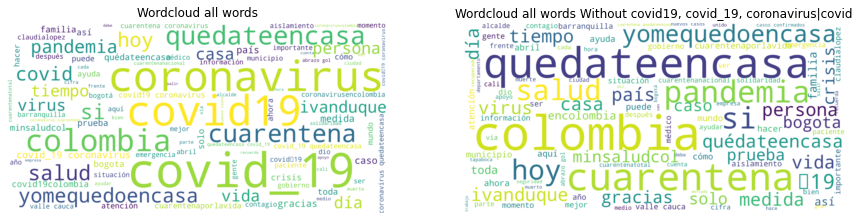

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].set_title('Wordcloud all words')
axes[1].set_title('Wordcloud all words Without covid19, covid_19, coronavirus|covid')

create_wordcloud(text.lower(), axes[0])
create_wordcloud(re.sub(r"covid19|covid_19|coronavirus|covid", "", text.lower()), axes[1])

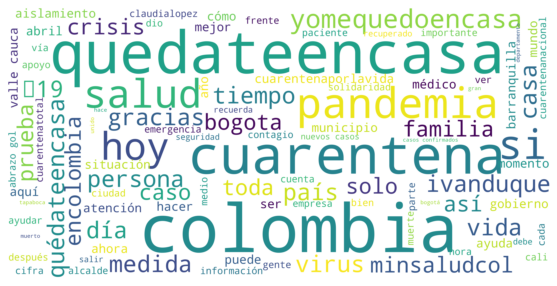

In [53]:
create_wordcloud(re.sub('(@\w*)|(#\w*)|(covid19)|(covid_19)|(coronavirus)|(covid)', '', text.lower()), plt)

### Just for curiosity we're going to see wordclouds for the ten most frequent cities of tweets

In [54]:
most_frequent_cities = [i[0] for i in cities_most_freq][::-1]
most_frequent_cities

['Montería',
 'Valledupar',
 'Bogotá',
 'Barranquilla',
 'Bucaramanga',
 'Santa Marta',
 'Medellín',
 'Cartagena',
 'Cali']

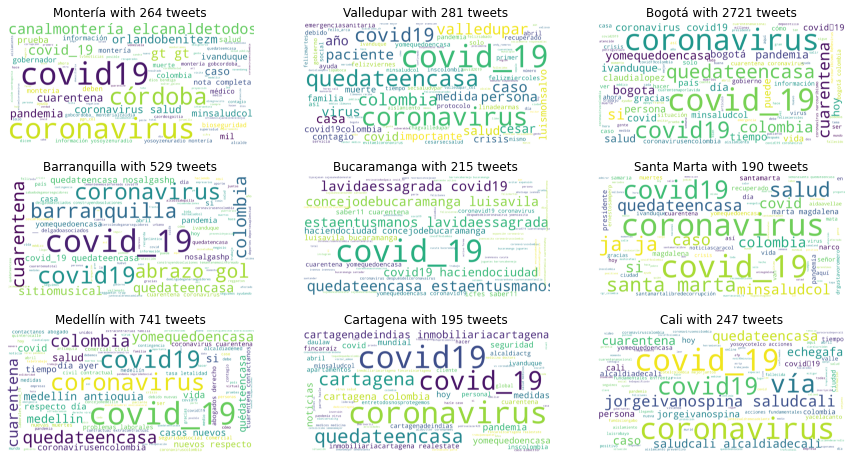

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [55]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
c = 0
for city in most_frequent_cities:
    temp_data = data3[data3['place_full_name'] == city].copy()
#     print(f"{city} has {temp_data.shape} tweets")
    temp_text = clean_text(" ".join(temp_data['text']))
    axes[c//3][c%3].set_title(f"{city} with {temp_data.shape[0]} tweets")
    create_wordcloud(temp_text.lower(), axes[c//3][c%3])
    c+=1


### Without [covid19|covid_19|coronavirus|covid]

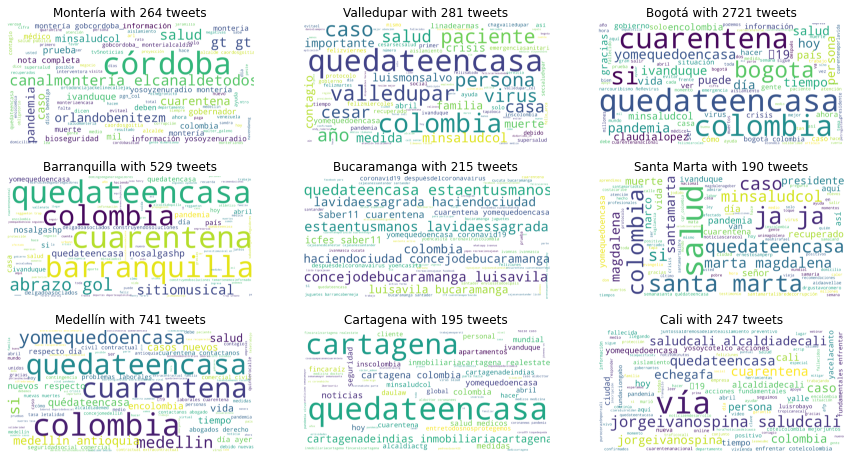

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [56]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
c = 0
for city in most_frequent_cities:
    temp_data = data3[data3['place_full_name'] == city].copy()
#     print(f"{city} has {temp_data.shape} tweets")
    temp_text = clean_text(" ".join(temp_data['text']))
    axes[c//3][c%3].set_title(f"{city} with {temp_data.shape[0]} tweets")
    create_wordcloud(re.sub(r"covid19|covid_19|coronavirus|covid", "", temp_text.lower()), axes[c//3][c%3])
    c+=1


In [57]:
data3['len_text'] = data3['text'].apply(lambda x: len(x))

(8909, 23)


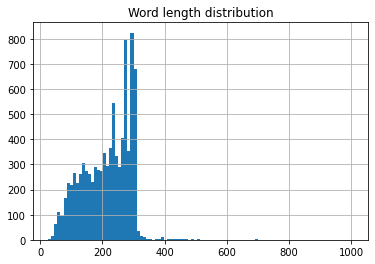

In [58]:
print(data3.shape)
plt.title('Word length distribution')
data3['len_text'].sort_values().hist(bins=100)

### Also we have plenty of hashtags, mentions and emojis. So, let's see what we got

#### Emojis

In [59]:
import regex

In [60]:
def get_emojis_(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [61]:
emojis_ = extract_emojis(text)
emojis_[:200]

'🙄👑\U0001f9a0🎛\U0001f9ee💱🚫🏡➡\U0001f9fc👏🚿😳\U0001f92a👺🤖👏🏻👏🏻👏🏻👏🏻👹👌💻👩🏻🔬💪🏽👨👩👧👦💦\U0001f932🏽\U0001f9fc🚫🚫🙏👇🏻⬇🔺🤕🔺\U0001f9a0🚫🏡➡👑\U0001f9a0\U0001f9fc👏🚿\U0001f9f4🚿💡🏨👌🏼⬇➡📲✅✅✅✅❤😴👉🥗🤸🏿♂❤➕👉🏾☎🐶🐱\U0001f90d💚🇨🇴💯\U0001f9a0😷🙏🏻💉💛💙💔\U0001f9a0📺💛❤🇨🇴🌎🌍🌏🙌🏼📱\U0001f92d🚫🏡➡🤦🏻🎞👌🏻💚🏘📚👆🏻🤒🤧\U0001f974🤕\U0001f9a0😷🇨🇴❤😷😔👵🏼👴🏼🎮🎲🎯🙏🏼👉🏻🤷🤦💡🚨🚨🚫🏡➡📸🇨🇴👇🙄😬😂😂😂😂😂😂🚫🏡➡\U0001f9fc👏🚿\U0001f9f4🤔💥👨👩👧👦🙏📺🏡👨👩👧👦🙏🙈🙉🙊🙏💪✌😎👊🥂🇺🇲😷☠'

In [62]:
# Counter(emojis_).most_common(50)

In [63]:
emojis2 = Counter(get_emojis_(text)).most_common()
x = [i[0] for i in emojis2]
y = [i[1] for i in emojis2]
print([i[0] for i in emojis2[1:250]])

['😷', '👏', '\U0001f9a0', '⬇️', '⤵️', '👉🏻', '👇', '👉', '👏🏻', '👇🏻', '📌', '❤️', '➡️', '✅', '🏡', '💚', '🙏', '🏠', '🙏🏻', '😂', '📲', '👇🏼', '🌎', '📍', '➡', '📱', '😔', '💛', '⚠️', '\U0001f92c', '💇', '🚫', '🙏🏼', '🚿', '🌍', '🌏', '🤔', '🛑', '🤝', '💻', '💙', '🙈', '💪', '👀', '🎥', '😭', '👏🏼', '😍', '🌐', '\U0001f9fc', '🙉', '👉🏼', '🙊', '👇🏽', '\U0001f970', '♻️', '📢', '🇵🇱', '🌄', '👉🏽', '📷', '➕', '🤗', '🏥', '🙄', '🚨', '🙌🏻', '👍', '👨🏻\u200d🚒', '👨🏻\u200d✈️', '🤵🏻', '👩🏻\u200d🔧', '✔️', '⬆️', '👨\u200d👩\u200d👧\u200d👦', '🏨', '👉🏾', '📺', '🙌🏼', '🤣', '😥', '💩', '🐾', '🎉', '✍🏼', '\U0001f92a', '💦', '💡', '☎️', '🐶', '💔', '🤦', '💫', '♥️', '🔴', '🙌', '👩\u200d⚕️', '👨\u200d⚕️', '😹', '💰', '👌', '💪🏽', '\U0001f9f4', '👌🏼', '🐱', '👌🏻', '📚', '👆🏻', '📸', '💥', '🐀', '\U0001f97a', '⭐', '\U0001f932', '🔝', '😓', '▪', '🚩', '😆', '\U0001f6f8', '💯', '💉', '😬', '😎', '👊', '😠', '😱', '\U0001f9d0', '☕', '✔', '⛔', '\U0001f9e4', '✨', '🗓', '🎶', '😒', '🍃', '🌈', '🤳', '😁', '🐕', '🇦🇷', '🤓', '🚕', '👨🏻\u200d⚕️', '🎂', '▶', '🗞', '🙌🏽', '📻', '🗣', '💧', '👏🏾', '🕴🏿', '👩🏻\u200d⚕️', '⏰', '🔼', '

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128079 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 10549 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128073 missing from current font.
  font

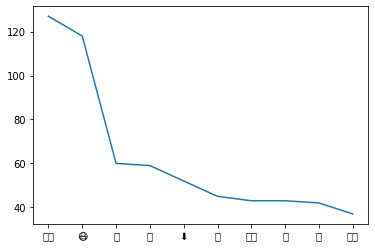

In [64]:
plt.plot(x[:10], y[:10])

### Hashtags

In [65]:
hashtags = get_hashtags(text)
print(len(hashtags))
print(hashtags[:50])

12769
['#Covid_19', '#Coronavirus', '#Covid_19', '#QueVainabella', '#Covid_19', '#SabadoDeGanarSeguidores', '#NoSalgasHP', '#QuedatenCasa', '#AlmuerzoBarro', '#Covid_19', '#QuedatenCasa', '#NoSalgasHP', '#SabadoDeGanarSeguidores', '#Cuarentena', '#coronavirus', '#caqueta', '#florencia', '#coronavírus', '#coronavirus', '#pandemia', '#pandemic', '#Covid19', '#colombia', '#coronavirus', '#Pasto', '#COVID19', '#Coronavirus', '#QuédateEnCasa', '#TodosSomosLaVacuna', '#NoDanElAncho', '#Covid_19', '#coronavirus', '#CODVID19', '#CoronavirusEnColombia', '#yourpower', '#tupoder', '#lahoradelplaneta', '#bellociudad', '#COVID19', '#coronaVirus', '#coronavirus', '#covid', '#covid_19', '#aislamiento', '#drone', '#MeQuedoEnCasa', '#CODVID19', '#Coronavirus', '#Covid19', '#VillavicencioCuentaContigo']


In [66]:
hashtags2 = Counter(hashtags).most_common(30)
x = [i[0] for i in hashtags2]
y = [i[1] for i in hashtags2]
print(hashtags2)

[('#Covid_19', 1165), ('#coronavirus', 807), ('#COVID19', 545), ('#QuedateEnCasa', 369), ('#Coronavirus', 327), ('#Covid19', 265), ('#cuarentena', 237), ('#Colombia', 182), ('#covid19', 178), ('#covid_19', 162), ('#YoMeQuedoEnCasa', 144), ('#COVIDー19', 131), ('#QuédateEnCasa', 128), ('#quedateencasa', 98), ('#Covid19Colombia', 84), ('#Cuarentena', 82), ('#CoronavirusEnColombia', 80), ('#colombia', 74), ('#CuarentenaPorLaVida', 71), ('#pandemia', 69), ('#CuarentenaNacional', 50), ('#yomequedoencasa', 46), ('#Salud', 45), ('#CoronavirusColombia', 42), ('#MeQuedoEnCasa', 36), ('#salud', 36), ('#CuarentenaTotal', 36), ('#NoSalgasHP', 35), ('#Huila', 35), ('#COVID_19', 34)]


In [67]:
# plt.figure(figsize=(10, 7))
# plt.barh(x[::-1], y[::-1])
x[:10]

['#Covid_19',
 '#coronavirus',
 '#COVID19',
 '#QuedateEnCasa',
 '#Coronavirus',
 '#Covid19',
 '#cuarentena',
 '#Colombia',
 '#covid19',
 '#covid_19']

### Daiy use of hashtags

In [68]:
df_count_hashtags = data3[['day']].drop_duplicates().copy()

In [69]:
ten_most_frequent_hashtags = x[:15]
dates = data3['day'].unique()

for hashtag in ten_most_frequent_hashtags:
    daily_use = []
    for date_ in dates:
        temp_df = data3[data3['day'] == date_].copy()
        daily_use.append(sum(temp_df['text'].apply(lambda x: 1 if hashtag in x else 0)))
    df_count_hashtags[hashtag] = daily_use

#     print(daily_use)

In [70]:
df_count_hashtags.head()

,day,#Covid_19,#coronavirus,#COVID19,#QuedateEnCasa,#Coronavirus,#Covid19,#cuarentena,#Colombia,#covid19,#covid_19,#YoMeQuedoEnCasa,#COVIDー19,#QuédateEnCasa,#quedateencasa,#Covid19Colombia
0,2020-03-29,155,83,59,21,49,28,19,23,13,18,15,5,7,6,7
386,2020-03-30,275,89,36,36,61,15,41,19,6,17,25,8,5,18,5
858,2020-03-31,139,123,89,42,57,33,37,14,13,21,23,9,4,7,8
1305,2020-04-01,109,120,80,33,67,39,22,27,16,11,13,25,9,11,12
1726,2020-04-02,83,111,74,20,49,31,14,22,21,13,7,33,8,3,5


In [71]:
df_count_hashtags.index = df_count_hashtags['day']

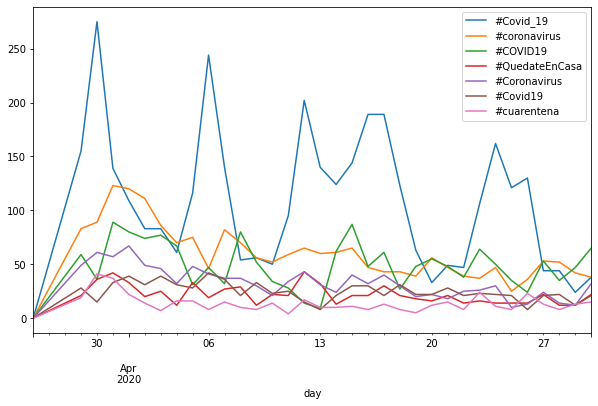

In [72]:
df_count_hashtags[df_count_hashtags.columns[1:8]].sort_index().plot(figsize=(10, 6))

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


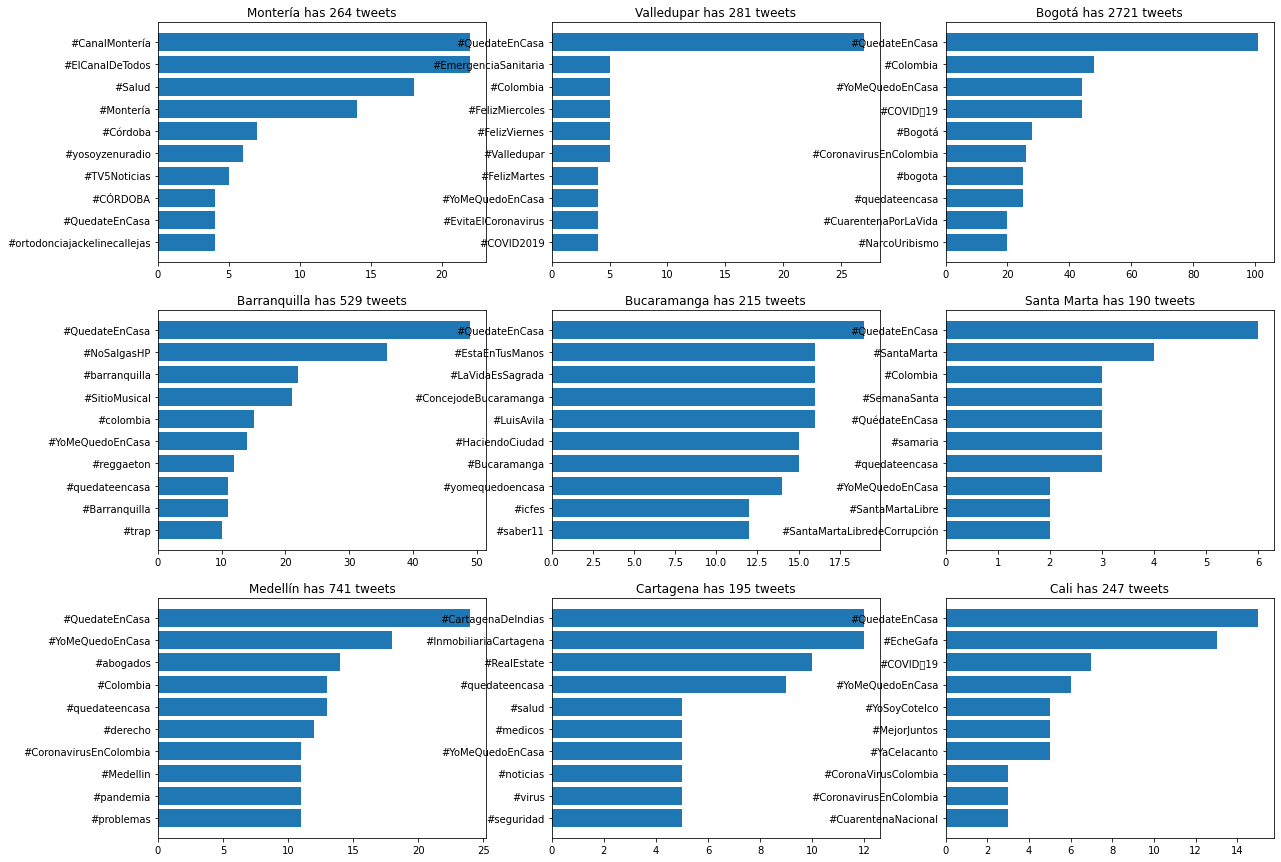

In [73]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
c=0
for city in most_frequent_cities:
    temp_data = data3[data3['place_full_name'] == city].copy()
#     print(f"{city} has {temp_data.shape} tweets")
    temp_text = clean_text(" ".join(temp_data['text']))
    temp_hashtags = get_hashtags(temp_text)
    temp_hashtags2 = Counter(temp_hashtags).most_common()
    del_covid_words = ["#covid", "#covid19", "#coronavirus", "#cuarentena", "#covid19colombia", "#covid_19"]
    temp_hashtags2 = [i for i in temp_hashtags2 if not i[0].lower() in del_covid_words][:10]
    x = [i[0] for i in temp_hashtags2]
    y = [i[1] for i in temp_hashtags2]
    axes[c//3][c%3].set_title(f"{city} has {temp_data.shape[0]} tweets")
    axes[c//3][c%3].barh(x[::-1], y[::-1])
    c+=1

### Mentions

In [74]:
mentions = get_mentions(text)
print(len(mentions))
# mentions[:15]

2805


In [75]:
mentions2 = Counter(mentions).most_common(25)
x = [i[0] for i in mentions2]
y = [i[1] for i in mentions2]
mentions2[:10]

[('@IvanDuque', 123),
 ('@MinSaludCol', 113),
 ('@JorgeIvanOspina', 58),
 ('@ClaudiaLopez', 53),
 ('@SaludCali', 44),
 ('@INSColombia', 35),
 ('@infopresidencia', 32),
 ('@AlcaldiaDeCali', 29),
 ('@SenadoGovCo', 29),
 ('@PGN_COL', 19)]

<BarContainer object of 25 artists>

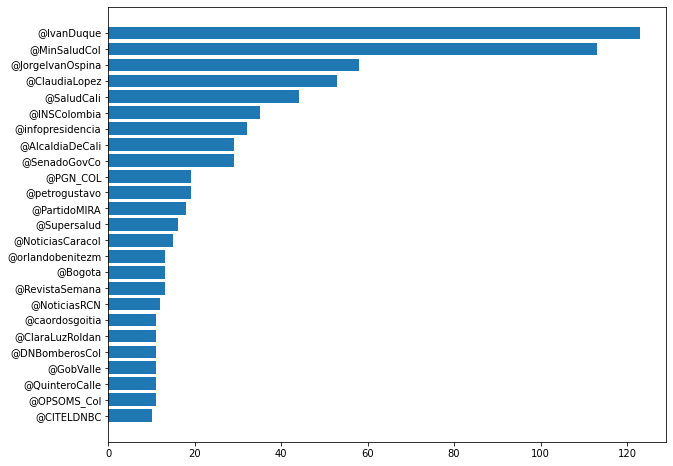

In [76]:
plt.figure(figsize=(10, 8))
plt.barh(x[::-1], y[::-1])

### Daily use of mentions

In [77]:
data3.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,place_full_name,place_type,followers_count,friends_count,account_created_at,verified,lang,source_tweet,day,len_text
0,1244051801516711938,803282972317204480,2020-03-29 00:00:37,redcomunitariat,Este lunes estaremos hablando sobre la situaci...,Twitter for iPhone,NaN,NaN,NaN,False,False,1119,4,Bogotá,city,2710,365,2016-11-28 17:02:39,False,es,https://twitter.com/redcomunitariat/status/124...,2020-03-29,188
1,1244052036511051778,2476348920,2020-03-29 00:01:33,SebasCamposCol,Aquí con frío🥶 viendo cómo pasa la cuarentena🕯...,Twitter for Android,NaN,NaN,NaN,False,False,768,0,Bogotá,city,4194,204,2014-05-04 04:11:55,False,es,https://twitter.com/SebasCamposCol/status/1244...,2020-03-29,101
2,1244052338412847104,239176842,2020-03-29 00:02:45,Jonathan_518,"Hoy es #sábado, apenas es hora de bañarme y or...",Twitter for iPhone,NaN,NaN,NaN,False,False,18,0,Guarne,city,286,914,2011-01-17 00:53:22,False,es,https://twitter.com/Jonathan_518/status/124405...,2020-03-29,108
3,1244054018407698442,364275627,2020-03-29 00:09:26,pablogonzale11,En el unico PAIS donde la Maquina pal' 👑🦠c dañ...,Twitter for Android,NaN,NaN,NaN,False,False,16852,0,Barranquilla,city,1734,3627,2011-08-29 14:12:57,False,es,https://twitter.com/pablogonzale11/status/1244...,2020-03-29,227
5,1244055449693028353,169728424,2020-03-29 00:15:07,NICOLUKAS1987,Para quienes tenemos mascotas creo que lo más ...,Twitter for Android,NaN,NaN,NaN,False,False,14924,0,senderos del parque 2,poi,908,2068,2010-07-23 01:15:04,False,es,https://twitter.com/NICOLUKAS1987/status/12440...,2020-03-29,301


In [78]:
def get_hashtags_(text):
    patter = re.compile(r"#(\w+)")
    all_hashtags = [f"#{i}" for i in patter.findall(text)]
    return all_hashtags

In [79]:
df_count_mentions = data3[['day']].drop_duplicates().copy()

In [80]:
data3['hashtags'] = data3['text'].apply(lambda x: get_hashtags_(x))

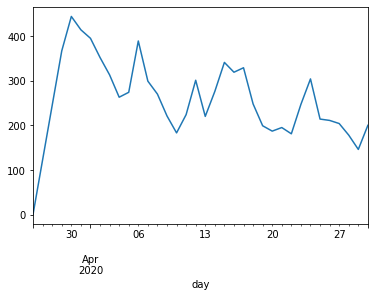

In [81]:
data3.groupby('day')['hashtags'].count().plot()

In [82]:
ten_most_frequent_mentions = x[:15]
dates = data3['day'].unique()

for mention in ten_most_frequent_mentions:
    daily_use = []
    for date_ in dates:
        temp_df = data3[data3['day'] == date_].copy()
        daily_use.append(sum(temp_df['text'].apply(lambda x: 1 if mention in x else 0)))
    df_count_mentions[mention] = daily_use

#     print(daily_use)

In [83]:
df_count_mentions.head()

,day,@IvanDuque,@MinSaludCol,@JorgeIvanOspina,@ClaudiaLopez,@SaludCali,@INSColombia,@infopresidencia,@AlcaldiaDeCali,@SenadoGovCo,@PGN_COL,@petrogustavo,@PartidoMIRA,@Supersalud,@NoticiasCaracol,@orlandobenitezm
0,2020-03-29,13,17,4,9,1,7,3,3,1,2,1,0,1,1,7
386,2020-03-30,20,15,1,5,0,7,12,1,3,2,4,0,4,0,0
858,2020-03-31,26,16,4,15,3,4,7,3,2,0,1,0,1,3,3
1305,2020-04-01,27,17,3,11,3,6,3,2,0,1,2,0,1,1,1
1726,2020-04-02,16,17,5,8,5,6,5,7,2,1,1,0,2,2,3


In [84]:
df_count_mentions.index=df_count_mentions['day']

In [85]:
# df_count_mentions.groupby('day').count().plot()

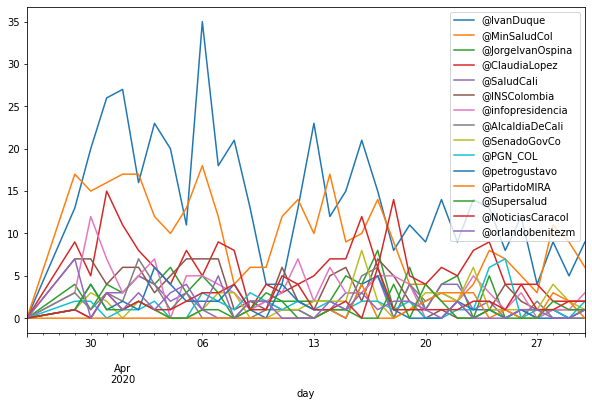

In [86]:
df_count_mentions[df_count_mentions.columns[1:]].sort_index().plot(figsize=(10,6))

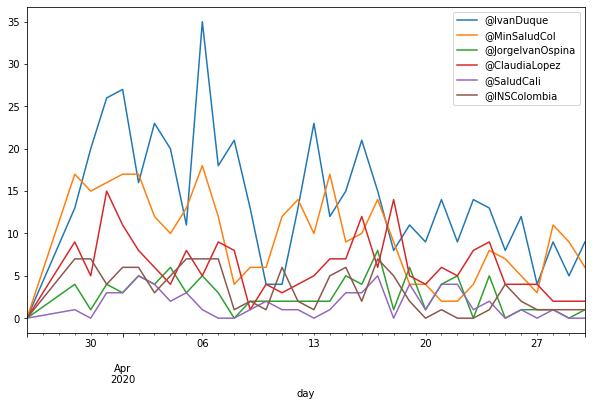

In [87]:
df_count_mentions[df_count_mentions.columns[1:7]].sort_index().plot(figsize=(10,6))

### Mentions separated by region

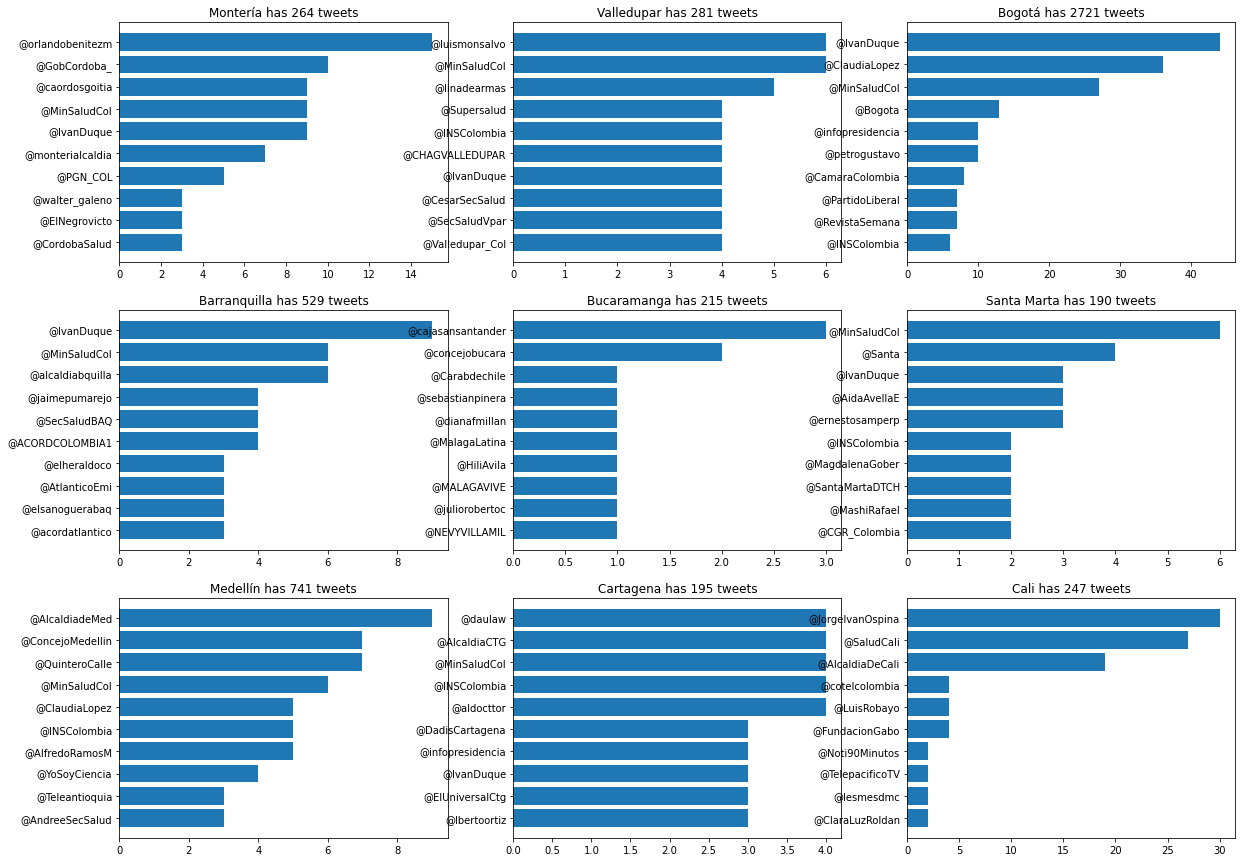

In [88]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
c=0
for city in most_frequent_cities:
    temp_data = data3[data3['place_full_name'] == city].copy()
#     print(f"{city} has {temp_data.shape} tweets")
    temp_text = clean_text(" ".join(temp_data['text']))
    temp_mentions = get_mentions(temp_text)
    temp_mentions2 = Counter(temp_mentions).most_common()
    del_covid_words = ["#covid", "#covid19", "#coronavirus", "#cuarentena", "#covid19colombia", "#covid_19"]
    temp_mentions2 = [i for i in temp_mentions2 if not i[0].lower() in del_covid_words][:10]
    x = [i[0] for i in temp_mentions2]
    y = [i[1] for i in temp_mentions2]
    axes[c//3][c%3].set_title(f"{city} has {temp_data.shape[0]} tweets")
    axes[c//3][c%3].barh(x[::-1], y[::-1])
    c+=1